In [1]:
import numpy as np
import sklearn.datasets
import umap
import scipy.sparse
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.collections import LineCollection
from sklearn.preprocessing import normalize

In [2]:
import igraph as ig
import leidenalg as la
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [3]:
digits = sklearn.datasets.load_digits()

In [4]:
mapper = umap.UMAP(n_neighbors=30).fit(digits.data)

KeyboardInterrupt: 

In [5]:
graph = mapper.graph_.copy()

In [6]:
graph.diagonal()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [7]:
def laplacian_from_graph(graph):
    laplacian = -graph
    laplacian.setdiag(np.zeros(graph.shape[0]))
    laplacian.setdiag(-np.squeeze(np.asarray(laplacian.sum(axis=1))))
    return laplacian

In [8]:
def compute_omega(graph):
    laplacian = laplacian_from_graph(graph)
    laplacian_pinv = np.linalg.pinv(laplacian.toarray())
    omega = np.zeros(graph.data.shape[0])
    coo_graph = graph.tocoo()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        omega[n] = laplacian_pinv[i, i] + laplacian_pinv[j, j] - laplacian_pinv[i, j] - laplacian_pinv[j, i]
            
    return omega, coo_graph

In [9]:
def compute_resistance_link_curvature(graph):
    omega, coo_graph = compute_omega(graph)
    relative_resistance = graph.copy()
    relative_resistance.data *= omega
    resistance_curvature = 1 - 0.5 * np.squeeze(np.asarray(relative_resistance.sum(axis=1)))
    resistance_link_curvature = coo_graph.copy()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        if omega[n] > 0:
            resistance_link_curvature.data[n] = 2 * (resistance_curvature[i] + resistance_curvature[j]) / omega[n]
        else:
            resistance_link_curvature.data[n] = 0.0
        
    return resistance_link_curvature.tocsr()

In [10]:
def iterate_curvature_flow(graph, i):
    omega, next_graph = compute_omega(graph)
    # print(omega)
    omega_scaling = (np.percentile(omega, 100 - 20 * np.power(2.0, -(i**2)/2)) - (omega))
#     omega_scaling = (np.percentile(omega, 95) - (omega))
    next_graph.data *= omega_scaling
#     next_graph.data /= omega
#     next_graph.data[omega_scaling < 0] = 0.0
#     next_graph = normalize(next_graph, norm="l1")
    next_graph.data[next_graph.data < 0] = 0.0
    next_graph = normalize(next_graph, norm="l1")# * np.log2(30)
#     next_graph /= next_graph.max()
    next_graph += next_graph.transpose()
    next_graph /= 2
#     next_graph = next_graph + next_graph.transpose() - next_graph.multiply(next_graph.transpose())
    next_graph.eliminate_zeros()
    return next_graph

In [11]:
# def curvature_flow(dataset_id = i):
    

In [ ]:
%%time
mapper = umap.UMAP(n_neighbors=15).fit(digits.data)
graph = mapper.graph_.copy()
for i in range(5):
    G = ig.Graph.Weighted_Adjacency(graph, 'undirected')
    clusterings = np.array(la.find_partition(G, la.ModularityVertexPartition).membership)
    print(i, adjusted_rand_score(digits.target, clusterings))
    graph = iterate_curvature_flow(graph, i)

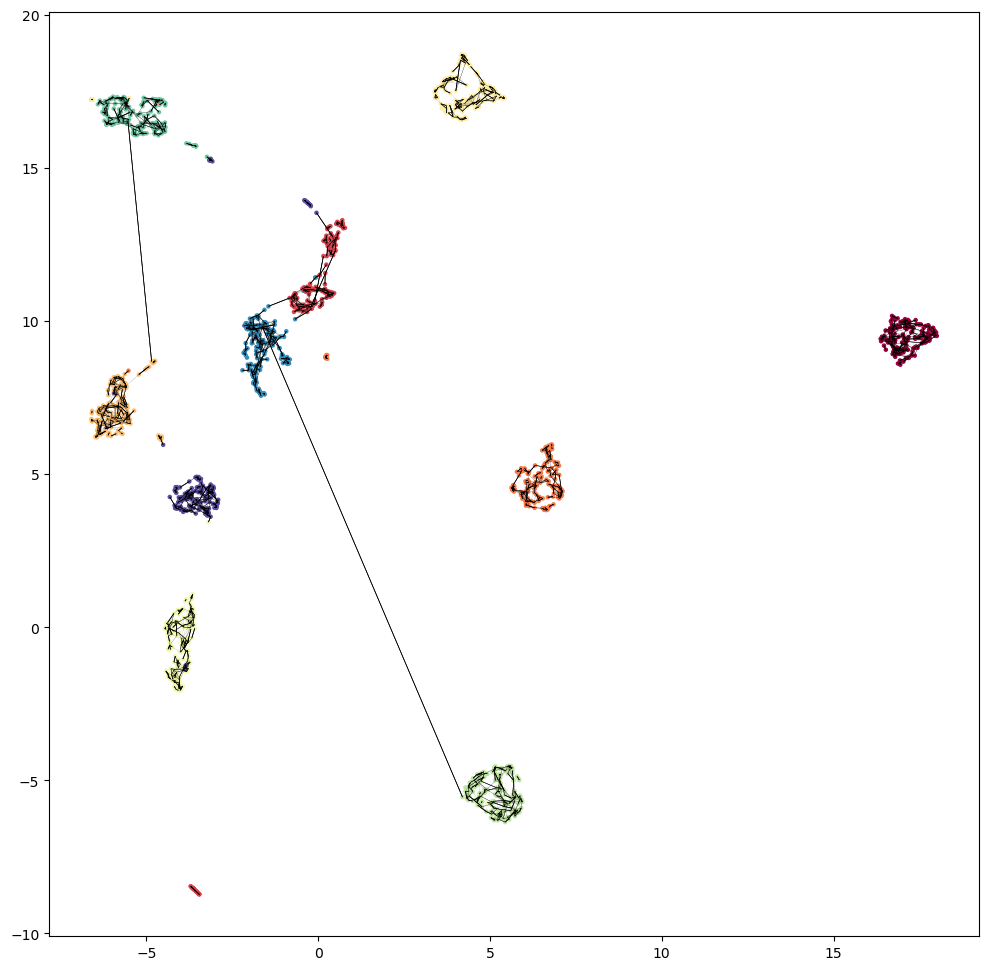

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = graph.tocoo()
edges = LineCollection(
    np.dstack([mapper.embedding_[coo_umap_graph.row], mapper.embedding_[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=np.clip(1e0 * coo_umap_graph.data, 0, 0.5),
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), np.clip(1e1 * coo_umap_graph.data, 0, 1)]).T,
    zorder=3
)
ax.add_collection(edges)
ax.scatter(*mapper.embedding_.T, s=5, c=digits.target, cmap="Spectral", zorder=0)

In [13]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [14]:
from scipy.stats import mode
def measure_refinement(reference, test_partition):
    ind_max = max(test_partition)+1
    ind_min = min(test_partition)
    not_in_dominant = 0
    for grp in range(ind_min,ind_max):
        sublabels = reference[test_partition==grp]
        sizeLarge = mode(sublabels)[1][0]
        not_in_dominant = not_in_dominant + (len(sublabels)-sizeLarge)
    return(1 - not_in_dominant/len(reference))

In [15]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [16]:
def evaluation_dataframe(cluster_labels, true_labels, raw_data, min_cluster_size=1):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo, min_cluster_size=min_cluster_size)
            for algo, algo_labels in cluster_labels.items() 
        ]
    )
    return(eval_results)

In [17]:
def curvature_on_datasets(dataset_id):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    print(dataset_name)
    
    graph, sigmas, rhos, dists = get_umap_graph(raw_data=raw_data, dataset_id=dataset_id, return_only_matrix=True)
    results = []
    for i in range(10):
        G = ig.Graph.Weighted_Adjacency(graph, 'undirected')
        clusterings = np.array(la.find_partition(G, la.ModularityVertexPartition).membership)
        results.append({'Step': i, 
                        'ARI' : adjusted_rand_score(targets, clusterings), 
                        'Dataset':dataset_name , 
                        'Nb of clusters': (max(clusterings)+1),
                        'Refinement' : measure_refinement(targets, clusterings)})
        graph = iterate_curvature_flow(graph, i)
    return(pd.DataFrame.from_dict(results))

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
res = []
for dataset_id in [1,3,4]:
    res.append(curvature_on_datasets(dataset_id=dataset_id))

coil
usps
buildings


In [21]:
other_results = pd.concat(res)
other_results

,Step,ARI,Dataset,Nb of clusters,Refinement
0,0,0.742554,coil,26,0.865972
1,1,0.545394,coil,92,0.949306
2,2,0.470951,coil,136,0.975000
3,3,0.388360,coil,179,0.978472
4,4,0.380338,coil,190,0.979861
5,5,0.367551,coil,193,0.979861
6,6,0.377499,coil,192,0.979861
7,7,0.377622,coil,192,0.979861
8,8,0.377622,coil,192,0.979861
9,9,0.378874,coil,193,0.979861


In [31]:
results_on_pendigits

,Step,ARI,Dataset,Nb of clusters,Refinement
0,0,0.882723,pendigits,12,0.957151
1,1,0.886234,pendigits,20,0.972732
2,2,0.817882,pendigits,29,0.986088
3,3,0.775119,pendigits,43,0.986644
4,4,0.750855,pendigits,58,0.987201
5,5,0.749454,pendigits,59,0.987201
6,6,0.748514,pendigits,60,0.987201
7,7,0.748514,pendigits,60,0.987201
8,8,0.748514,pendigits,60,0.987201
9,9,0.748514,pendigits,60,0.987201
